In [13]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shdom



In [14]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

def projection_split(projections, n_parts):
    avg = len(projections.projection_list) / float(n_parts)
    out = []
    last = 0.0

    while last < len(projections.projection_list):
        out.append(shdom.MultiViewProjection(projections.projection_list[int(last):int(last + avg)]))
        last += avg

    return out

In [15]:
# Set data directory
data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
# data_dir = '../AirMSPI/21views'

format_ = '*.hdf'  # load
paths = sorted(glob.glob(data_dir + '/' + format_))
# roi = [[1088, 1408, 600, 1000], [1156, 1480, 640, 1000], [1216, 1556, 696, 1100], [1280, 1620, 732, 1100], [1340, 1684, 792, 1200], [1404, 1744, 828, 1200], [1460, 1812, 950, 1300], [1528, 1884, 1000, 1400], [1492, 1852, 1100, 1650]]
import scipy.io as sio
# roi=(shdom.AirMSPIMeasurements().select_region_of_interest(data_dir,0))
# roi = [[1164, 1460, 1400, 1800]]*21
roi = [[1288, 1608, 588, 835], [1356, 1680, 640, 892], [1416, 1756, 696, 940], [1480, 1820, 732, 992], [1540, 1884, 792, 1036], [1604, 1944, 828, 1085], [1660, 2012, 884, 1140], [1728, 2084, 936, 1190], [1792, 2152, 980, 1255]]

wavelengths = [660]#355, 380, 445, 470, 555, 660, 865, 935
airmspi_measurements = shdom.AirMSPIDynamicMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=wavelengths)
projections = airmspi_measurements._projections



In [16]:
"""
Set settings
"""
wavelengths = np.array(wavelengths)/1000
num_of_viewed_medium = len(projections.projection_list)
# input_cloud = 'rico52x57x26'
input_cloud = 'rico32x37x26'
# input_cloud = 'WIZ'

if len(wavelengths) > 1:
    type = 'polychromatic'
else:
    type = 'monochromatic'


output_dir = 'experiments/{}_wl_{}_img_{}_projection_{}/dynamic_medium_{}'.format(input_cloud, np.array_str(np.array(wavelengths)).replace(" ", ","), 
                                                                                   num_of_viewed_medium, 'AirMSPI',type)

# sun
sun_azimuth_list=airmspi_measurements.sun_azimuth_list
sun_zenith_list=airmspi_measurements.sun_zenith_list

# solver
iter = 10

In [17]:
# Mie scattering for water droplets
mie_table_paths = [
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]

In [18]:
# Load a Microphysical scatterer
droplets = shdom.MicrophysicalScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/{}.txt'.format(input_cloud), veff=0.1)
    time_list = airmspi_measurements.time_list
else:
    data_dir = '../synthetic_cloud_fields/WIZ_Clouds/BOMEX2'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    volumes_paths = volumes_paths[20:]
    droplets.load_from_csv(volumes_paths[0])

    time_list=[]
    for volumes_path in zip(volumes_paths):
        s = volumes_path[0]
        time_list.append(int(s[s.rfind('_')+1:s.rfind('.txt')]))
    time_list = np.array(time_list)/2 # to sec
    time_list -= time_list.min()
    t_ind = np.abs(np.subtract.outer(airmspi_measurements.time_list,time_list)).argmin(axis=1)
    volumes_paths = np.array(volumes_paths)[t_ind]
    time_list = time_list[t_ind]

In [33]:
droplets.lwc.data[:,:,:] = 10
# droplets.load_from_csv(volumes_paths[0])

com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])


TypeError: 'GridData' object does not support item assignment

In [20]:
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))


In [21]:
air = shdom.MultispectralScatterer()
mie_list = []
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
        # Molecular Rayleigh scattering
        rayleigh = shdom.Rayleigh(wavelength)
        rayleigh.set_profile(temperature_profile.resample(air_grid))
        air.add_scatterer(rayleigh.get_scatterer())
        mie = shdom.MiePolydisperse()
        mie.read_table(table_path)
        mie_list.append(mie)
        
temporary_scatterer_list = []
N_grid =10
grid = shdom.Grid(x=np.linspace(com_x-0.5,com_x+0.5,N_grid),y=np.linspace(com_y-0.5,com_y+0.5,N_grid),z=np.linspace(com_z-0.5,com_z+0.5,N_grid))
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    for mie in mie_list:  
        droplets.add_mie(mie)
else:
    grid = shdom.Grid(x=np.linspace(droplets.grid.xmin+0.5,droplets.grid.xmax-0.5,30),y=np.linspace(droplets.grid.ymin+0.5,droplets.grid.ymax-0.5,30),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax-2,30))
    for volumes_path, time in zip(volumes_paths, time_list):
        droplets = shdom.MicrophysicalScatterer()
        droplets.load_from_csv(volumes_path)
        for mie in mie_list:  
            droplets.add_mie(mie)
        # pad with zeros
        for data in [droplets.lwc.data, droplets.reff.data, droplets.veff.data]:
            data[0,:,:] = 0
            data[:,0,:] = 0
            data[:,:,0] = 0
            data[-1,:,:] = 0
            data[:,-1,:] = 0
            data[:,:,-1] = 0
        
        temporary_scatterer_list.append(shdom.TemporaryScatterer(droplets,time))
        


Reading mie table from file: ../mie_tables/polydisperse/Water_660nm.scat


In [22]:
dynamic_scatterer = shdom.DynamicScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    dynamic_scatterer.generate_dynamic_scatterer(scatterer=droplets, time_list=airmspi_measurements.time_list, scatterer_velocity_list=[0,0,0])
else:
    dynamic_scatterer.add_temporary_scatterer(temporary_scatterer_list)

dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [23]:
surface = shdom.LambertianSurface(albedo=0.2)
wl_scene_params_list = []
wl_numerical_params_list = []
for sun_azimuth, sun_zenith in zip(sun_azimuth_list, sun_zenith_list):
    scene_params_list = []
    numerical_params_list = []
    for wavelength in wavelengths:
        scene_params = shdom.SceneParameters(
            wavelength=wavelength,
            surface=surface,
            source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith)
        )
        scene_params_list.append(scene_params)
        numerical_params = shdom.NumericalParameters(num_mu_bins=8, num_phi_bins=16)
        numerical_params_list.append(numerical_params)
    wl_scene_params_list.append(scene_params_list)
    wl_numerical_params_list.append(numerical_params_list)

In [24]:
dynamic_solver = shdom.DynamicRteSolver(scene_params=wl_scene_params_list,numerical_params=wl_numerical_params_list)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter,verbose=True)

In [25]:
for pro in projections.projection_list:
    pro._x -= 1
    pro._y -= 1
dynamic_projection = shdom.DynamicProjection(projection_split(projections, num_of_viewed_medium))

In [26]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), dynamic_projection)
images = dynamic_camera.render(dynamic_solver,n_jobs=40)

In [27]:
images = [image * (mask*1) for image, mask in zip(images, airmspi_measurements._mask_list)] 

In [28]:
measurements = shdom.DynamicMeasurements(camera=dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)

In [29]:
shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)

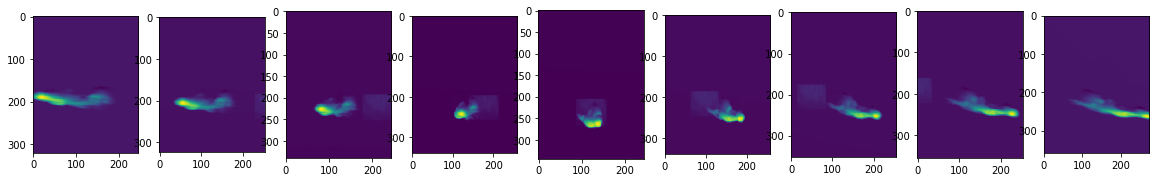

In [30]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, images):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    # image -= image.min()
    ax.imshow(image)


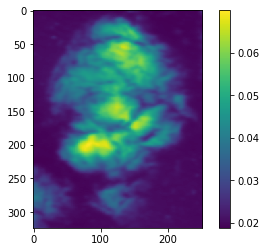

In [31]:
plt.imshow(airmspi_measurements.images[1])
plt.colorbar()
# # %matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init()
# x_min = projections.x.min()
# x_max = projections.x.max()
# y_min = projections.y.min()
# y_max = projections.y.max()
# projections.projection_list[3].plot(ax,[1, 3],[y_min, 0],[0, 20],20)

In [32]:
a,b,c = shdom.load_dynamic_forward_model(output_dir)
print()
  
